In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
from tabulate import tabulate
from shapely import Point, MultiPoint, LineString, affinity

In [6]:
file = Path().resolve()
parent, root = file.parent, file.parents[1]

# add the location of the root folder (zeroheliumkit) to the PATH
sys.path.append(str(root))

# Additionally remove the current file's directory from sys.path
try:
    sys.path.remove(str(parent))
except ValueError: # Already removed
    pass

In [7]:
from zeroheliumkit import (Entity, MicroChannels, Taper, SpiralInductor, IDC, GeomCollection,
                           ArcLine, Meander, Rectangle)
from zeroheliumkit.src.functions import merge_lines_with_tolerance
from zeroheliumkit.src.settings import COLORS, SIZE, SIZE_L
from zeroheliumkit.helpers.resonator_calc import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

### **RES uChannels** 

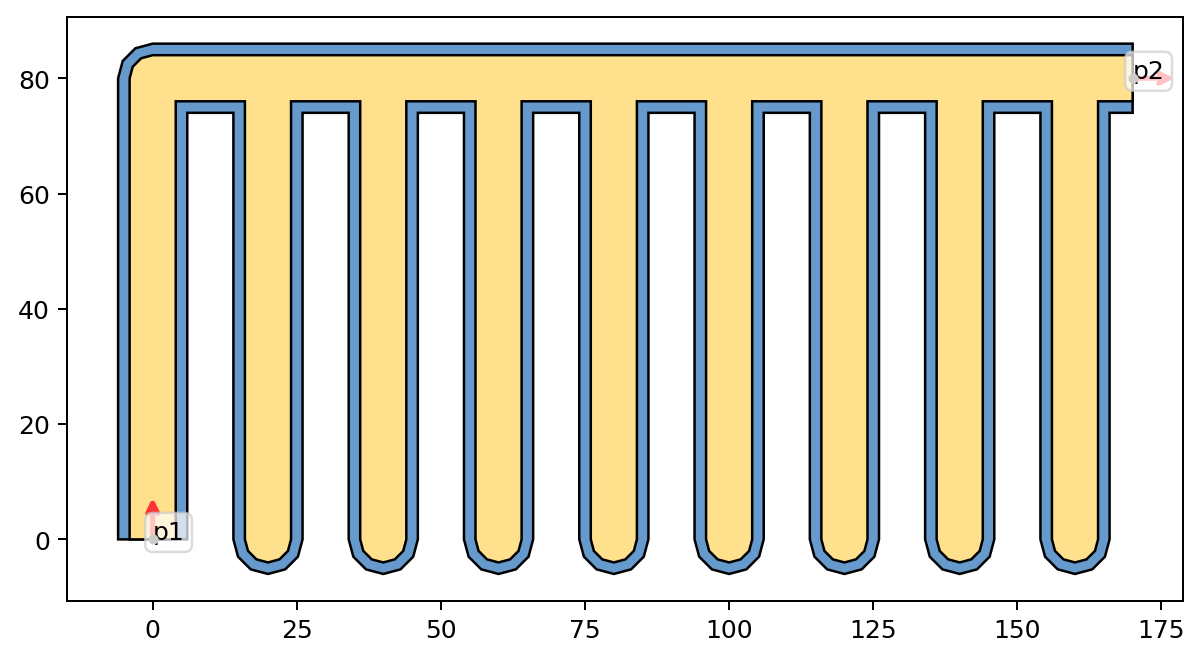

In [8]:
RES_layer_info = {"metal": 8,
                  "etch": 12}
reservior = MicroChannels(length=80, 
                           spacing=20,
                           num=9,
                           angle=0,
                           layers=RES_layer_info,
                           alabel=("p1", "p2"))

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
reservior.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Taper**

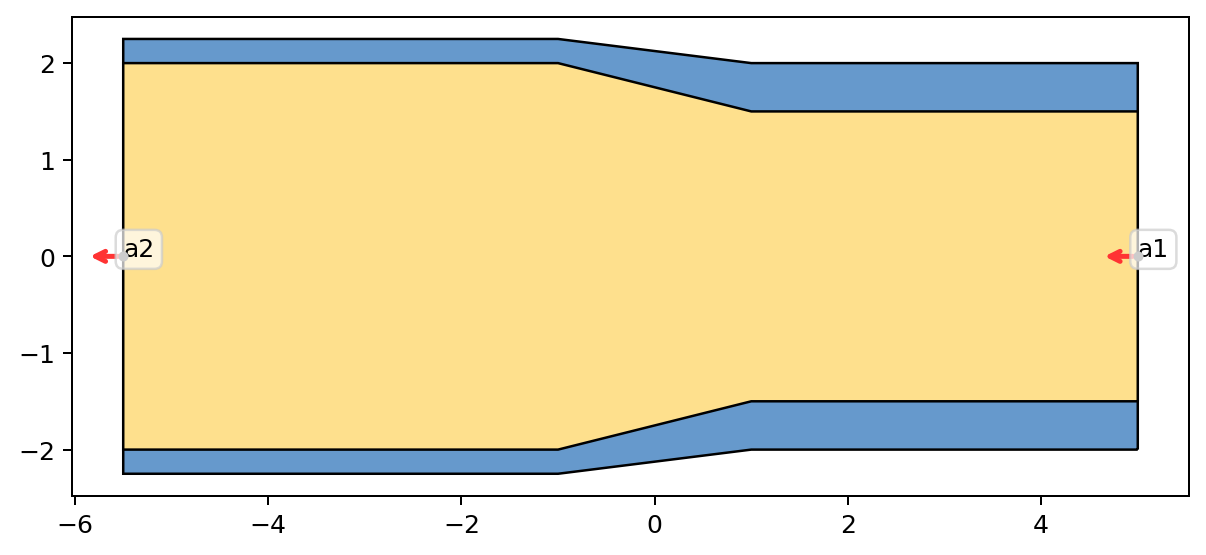

In [9]:
layer_info = {"metal": (3, 4),
              "etch": (3 + 1, 4 + 0.5)}
tp = Taper(length=2,
           layers=layer_info,
           alabel=("a1","a2"))

tp.scale(-1, 1, origin=(0,0))

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
tp.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Spiral Inductor** <a name="introduction"></a>

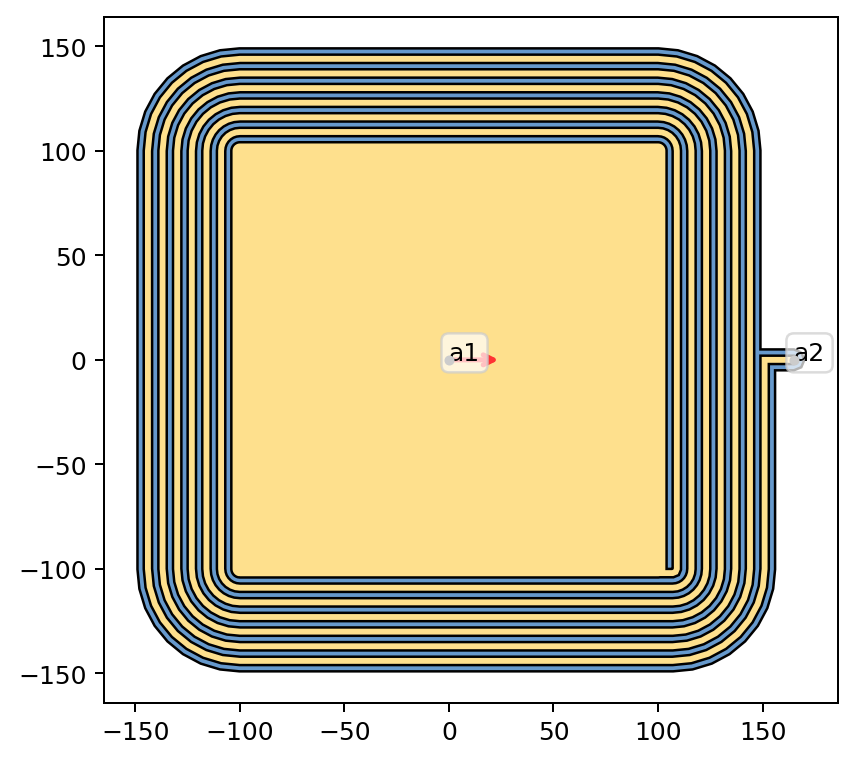

In [10]:
layer_info = {"metal": 4,
              "etch": 10}
spI = SpiralInductor(size = 200, 
                    width = 4, 
                    gap = 3, 
                    num_turns = 6, 
                    smallest_section_length = 0.5,
                    layers = layer_info,
                    alabel=("a1", "a2"))

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
spI.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()
#spI.save_to_file("spiral_inductor")

### **IDC**

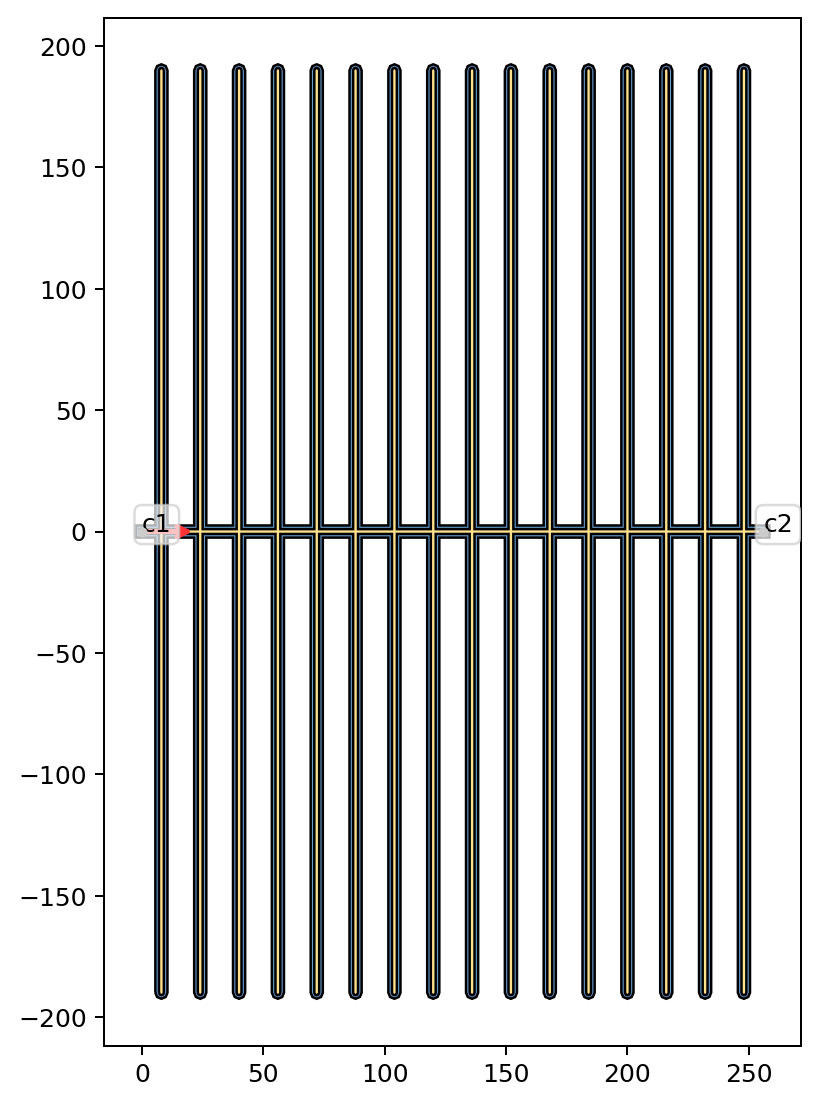

In [11]:
layer_info = {"metal": 2,
              "etch": 5}
idc = IDC(length=190, 
          spacing=16, 
          num=15, 
          layers=layer_info,
          alabel=("c1", "c2"))

fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
idc.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **CPW Launcher**

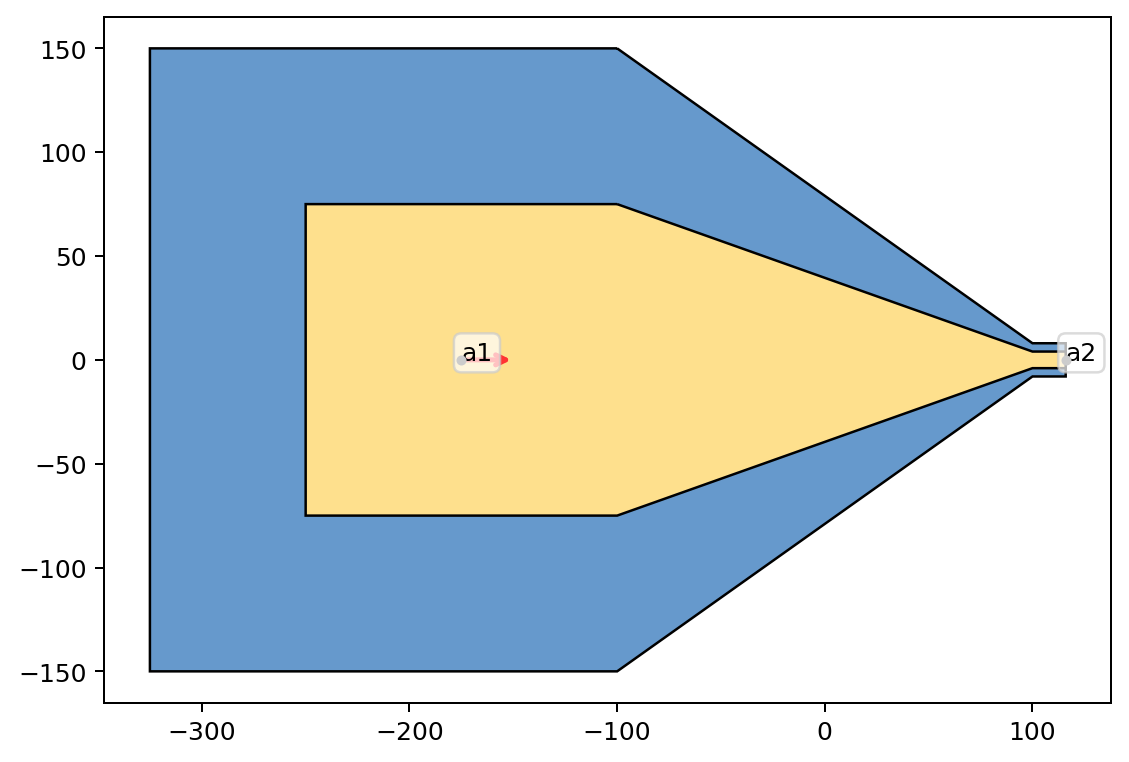

In [12]:
cpwlauncher = Taper(length = 200,
                    layers = {"top": (150, 8),
                              "gnd": (300, 16)},
                              alabel=("a1","a2"))
cpwlauncher.cut_polygon("top", Rectangle(150, 200, (-325,0)))
cpwlauncher.cut_polygon("gnd", Rectangle(75, 400, (-325-75/2,0)))
cpwlauncher.get_anchor("a1").move(225)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
cpwlauncher.plot(ax=ax, layer=["gnd", "top", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()